In [2]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import scipy.stats as stats

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# 0. Carga de los datos

In [4]:
import os 
ruta = os.getcwd()
print(ruta)

/Users/duman/Documents/universidad/7semestre/BI/BI-202302/Lab2


In [74]:
df_laptops_train = pd.read_csv('./data/laptop_data_train.csv', sep=',', encoding='utf-8')

In [75]:
df_laptops_train.shape
#

(1216, 14)

In [76]:
df_laptops_train.sample(5)

,id,Company,TypeName,Ram,Weight,Price,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
271,530,Dell,Gaming,16,4.420000,11.986176,0,1,127.335675,Intel Core i7,1000.0,128,Nvidia,Windows
520,662,Lenovo,Notebook,4,50.777808,10.257828,0,0,NaN,Intel Core i5,NaN,0,Intel,Windows
249,1202,Dell,Ultrabook,16,NaN,274.559205,1,0,276.053530,Intel Core i7,0.0,512,Intel%%,Windows
686,845,Dell,Notebook,4,2.180000,10.580859,0,0,141.211998,Intel Core i7,0.0,256,AMD,Windows
714,671,Lenovo,Notebook,8,1.900000,10.682362,0,0,141.211998,Intel Core i5,1000.0,128,AMD,Windows


In [77]:
df_laptops_unlabeled = pd.read_csv('./data/laptop_data_test_unlabeled.csv', sep=',', encoding='utf-8')

In [78]:
df_laptops_unlabeled.shape

(64, 14)

In [79]:
df_laptops_unlabeled.sample(5)

,id,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os,CalculatedPrice
9,981,Toshiba,Notebook,4,1.20,0,0,165.632118,Intel Core i5,0.0,128,Intel,Windows,NaN
58,274,Toshiba,&&Notebook,8,2.20,0,0,100.454670,Intel Core i7,500.0,0,Nvidia,Windows,NaN
21,193,Lenovo,Notebook,8,2.80,0,0,106.113062,Intel Core i5,0.0,256,Nvidia,Others,NaN
12,64,HP,Notebook,8,1.86,0,0,141.211998,Intel Core i5,0.0,256,Intel,Windows,NaN
14,1093,Dell,Ultrabook,4,1.40,0,1,165.632118,Intel Core i5,0.0,256,AMD,Windows,NaN


In [80]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1216 non-null   int64  
 1   Company      1216 non-null   object 
 2   TypeName     1216 non-null   object 
 3   Ram          1216 non-null   int64  
 4   Weight       1193 non-null   float64
 5   Price        1201 non-null   float64
 6   TouchScreen  1216 non-null   int64  
 7   Ips          1216 non-null   int64  
 8   Ppi          1204 non-null   float64
 9   Cpu_brand    1216 non-null   object 
 10  HDD          1200 non-null   float64
 11  SSD          1216 non-null   int64  
 12  Gpu_brand    1216 non-null   object 
 13  Os           1216 non-null   object 
dtypes: float64(4), int64(5), object(5)
memory usage: 133.1+ KB


In [81]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216 entries, 0 to 1215
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1216 non-null   int64  
 1   Company      1216 non-null   object 
 2   TypeName     1216 non-null   object 
 3   Ram          1216 non-null   int64  
 4   Weight       1193 non-null   float64
 5   Price        1201 non-null   float64
 6   TouchScreen  1216 non-null   int64  
 7   Ips          1216 non-null   int64  
 8   Ppi          1204 non-null   float64
 9   Cpu_brand    1216 non-null   object 
 10  HDD          1200 non-null   float64
 11  SSD          1216 non-null   int64  
 12  Gpu_brand    1216 non-null   object 
 13  Os           1216 non-null   object 
dtypes: float64(4), int64(5), object(5)
memory usage: 133.1+ KB


# 1. Entendimiento y limpieza de los datos

In [82]:
# Eleccion de variables relevantes para calcular el precio de un computador
features = [
    'Company',
    'TypeName',
    'Ram',
    'Weight',
    'TouchScreen',
    'Ips',
    'Ppi',
    'Cpu_brand',
    'HDD',
    'SSD',
    'Gpu_brand',
    'Os'
]
featuresCategoricas = ['Company', 'TypeName', 'TouchScreen', 'Ips', 'Cpu_brand', 'Gpu_brand', 'Os']
featuresNumericas = ['Ram', 'Weight', 'Ppi', 'HDD', 'SSD']

# Eliminar variables no en features (id)
df_laptops_train = df_laptops_train[['Price'] + features]
df_laptops_unlabeled = df_laptops_unlabeled[features]


### 1.1. Verificacion de atributos de calidad de datos

#### Consistencia: Valores únicos en las variables categóricas

In [83]:
# verificar valores unicos en cada variable categorica
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_train[feature].unique()}')

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation' '2 in 1 Convertible%%' 'Gaming%%' '&&Notebook'
 '&&Ultrabook' 'Notebook%%' '&&Gaming' '&&2 in 1 Convertible']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD' 'Intel%%' 'Nvidia%%' '&&Intel' '&&Nvidia' 'AMD%%'
 '&&AMD']
Os: ['Others' 'Windows' 'Mac']


**Resultados:** Se puede observar que las variables 'TypeName' y 'Gpu_brand' tienen valores con caracteres extraños. Se procederá a eliminarlos para corregir esta información.

In [84]:
# Eliminar caracteres "&&", "%%", en las variables categoricas 'TypeName' y 'Gpu_brand'

def eliminar_caracteres(df_laptops_trains):
    df_laptops_train['TypeName'] = df_laptops_train['TypeName'].str.replace('&&', '').str.replace('%%', '')
    df_laptops_train['Gpu_brand'] = df_laptops_train['Gpu_brand'].str.replace('%%', '').str.replace('&&', '')


In [85]:
# verificar valores unicos en cada variable categorica de datos de test
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_unlabeled[feature].unique()}')
    

Company: ['HP' 'Lenovo' 'MSI' 'Asus' 'Acer' 'Toshiba' 'Dell' 'Mediacom']
TypeName: ['Notebook' 'Gaming' 'Ultrabook' '2 in 1 Convertible' 'Netbook'
 '&&Notebook']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'Other Intel Processor'
 'AMD Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Os: ['Windows' 'Others']


In [87]:
# Eliminar caracteres "&&", "%%", en las variables categoricas 'TypeName' y 'Gpu_brand' de datos de test
df_laptops_unlabeled['TypeName'] = df_laptops_unlabeled['TypeName'].str.replace('&&', '').str.replace('%%', '')
df_laptops_unlabeled['Gpu_brand'] = df_laptops_unlabeled['Gpu_brand'].str.replace('%%', '').str.replace('&&', '')

In [88]:
#Verificación de valores unicos en cada variable categorica luego de eliminar caracteres "&&", "%%"
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_train[feature].unique()}')

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Os: ['Others' 'Windows' 'Mac']


In [89]:
# Verificar valores unicos en cada variable categorica de datos de test luego de eliminar caracteres "&&", "%%"
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_unlabeled[feature].unique()}')

Company: ['HP' 'Lenovo' 'MSI' 'Asus' 'Acer' 'Toshiba' 'Dell' 'Mediacom']
TypeName: ['Notebook' 'Gaming' 'Ultrabook' '2 in 1 Convertible' 'Netbook']
TouchScreen: [0 1]
Ips: [0 1]
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'Other Intel Processor'
 'AMD Processor']
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Os: ['Windows' 'Others']


Se corrigieron los valores con caracteres extraños.

In [21]:
# Función que compara la cantidad de valores únicos en cada variable categorica entre los datos de entrenamiento y los datos de test
def compararValoresUnicos(df_train, df_test, featuresCategoricas):
    for feature in featuresCategoricas:
        print(f'{feature}: {df_train[feature].unique()}')
        print(f'{feature}: {df_test[feature].unique()}')
        print(f'{feature}: {df_train[feature].unique().shape}')
        print(f'{feature}: {df_test[feature].unique().shape}')
        print('------------------------')

compararValoresUnicos(df_laptops_train, df_laptops_unlabeled, featuresCategoricas)
    

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Razer' 'Samsung'
 'Chuwi' 'Microsoft' 'Mediacom' 'LG' 'Vero' 'Apple' 'Huawei' 'Xiaomi'
 'Fujitsu' 'Google']
Company: ['HP' 'Lenovo' 'MSI' 'Asus' 'Acer' 'Toshiba' 'Dell' 'Mediacom']
Company: (19,)
Company: (8,)
------------------------
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Workstation']
TypeName: ['Notebook' 'Gaming' 'Ultrabook' '2 in 1 Convertible' 'Netbook']
TypeName: (6,)
TypeName: (5,)
------------------------
TouchScreen: [0 1]
TouchScreen: [0 1]
TouchScreen: (2,)
TouchScreen: (2,)
------------------------
Ips: [0 1]
Ips: [0 1]
Ips: (2,)
Ips: (2,)
------------------------
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'Other Intel Processor'
 'AMD Processor']
Cpu_brand: (5,)
Cpu_brand: (5,)
------------------------
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Gpu_brand: ['Intel' 

In [184]:
# Función que compara la cantidad de registro por cada valor único en cada variable categorica entre los datos de entrenamiento y los datos de test
def compararCantidadRegistros(df_train, df_test, featuresCategoricas):
    for feature in featuresCategoricas:
        print("para la variable: ", feature)
        print(f'{feature}: {df_train[feature].value_counts()}')
        print(f'{feature}: {df_test[feature].value_counts()}')
        print('------------------------')
        
compararCantidadRegistros(df_laptops_train, df_laptops_unlabeled, featuresCategoricas)

para la variable:  Company
Company: Company
Lenovo            281
Dell              276
HP                255
Asus              141
Acer               96
Others_Company     66
MSI                50
Toshiba            45
Mediacom            6
Name: count, dtype: int64
Company: Company
Dell        15
HP          13
Lenovo      13
Asus        10
Acer         5
MSI          4
Toshiba      3
Mediacom     1
Name: count, dtype: int64
------------------------
para la variable:  TypeName
TypeName: TypeName
Notebook              670
Gaming                196
Ultrabook             188
2 in 1 Convertible    112
Others_TypeName        29
Netbook                21
Name: count, dtype: int64
TypeName: TypeName
Notebook              39
Gaming                 9
Ultrabook              8
2 in 1 Convertible     6
Netbook                2
Name: count, dtype: int64
------------------------
para la variable:  TouchScreen
TouchScreen: TouchScreen
0    1039
1     177
Name: count, dtype: int64
TouchScreen: Touch

Se puede observar que el dataset de entrenamiento tiene más valores únicos en varias categorías que el dataset de prueba. Se procede a unir los registros de los valores únicos del dataset de entrenamiento que no se encuentran en el dataset de prueba. 

In [114]:
# Funcion que identifica valores unicos en dataset de entrenamiento que no están en dataset de prueba
def identificarValoresUnicos(df_train, df_test, featuresCategoricas)-> list:
    featuresDiferentes = {}
    for feature in featuresCategoricas:
        featuresDiferentes[feature] = np.setdiff1d(df_train[feature].unique(), df_test[feature].unique())
        # convertir array a lista
        featuresDiferentes[feature] = featuresDiferentes[feature].tolist()   
    # imprimir valores diferentes
    print(featuresDiferentes)
    return featuresDiferentes
    

    

In [167]:
# Verificar valores distintos entre los datos de entrenamiento y los datos de test
featuresDiferentes = identificarValoresUnicos(df_laptops_train, df_laptops_unlabeled, featuresCategoricas)


{'Company': ['Apple', 'Chuwi', 'Fujitsu', 'Google', 'Huawei', 'LG', 'Microsoft', 'Razer', 'Samsung', 'Vero', 'Xiaomi'], 'TypeName': ['Workstation'], 'TouchScreen': [], 'Ips': [], 'Cpu_brand': [], 'Gpu_brand': [], 'Os': ['Mac']}


In [189]:
# Backup de datasets
df_laptops_train_bk = df_laptops_train.copy()
df_laptops_unlabeled_bk = df_laptops_unlabeled.copy()

In [188]:
# volver al backup
df_laptops_train = df_laptops_train_bk.copy()
df_laptops_unlabeled = df_laptops_unlabeled_bk.copy()


In [219]:
# ver datos de entrenamiento
df_laptops_train.sample(5)

,Price,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
786,10.595634,Dell,Notebook,8,2.18,0,0,141.211998,Intel Core i5,0.0,256,Intel,Windows
636,11.921471,Lenovo,2 in 1 Convertible,16,1.42,1,0,209.800683,Intel Core i7,0.0,1000,Intel,Windows
942,11.022208,HP,Ultrabook,8,1.39,1,0,276.053530,Intel Core i7,0.0,256,Intel,Windows
130,12.030401,Dell,Gaming,32,4.42,0,1,127.335675,Intel Core i7,1000.0,256,Nvidia,Windows
254,11.402110,Dell,Ultrabook,8,1.36,0,0,157.350512,Intel Core i7,0.0,512,Intel,Windows


In [187]:
# Reemplazar valores de features desconocidos por "Others"


def reemplazarValoresDesconocidos(df_train, featuresCategoricas, featuresDiferentes):
    for feature in featuresCategoricas:
        # Verificar si ya existe la categoria "Others" en la variable categorica
        if feature == 'Os':
           df_train[feature] = df_train[feature].replace(featuresDiferentes[feature], 'Others')
        else:
            df_train[feature] = df_train[feature].replace(featuresDiferentes[feature], 'Others' + "_" + feature)
    return df_train

In [220]:
#Modificar valores
reemplazarValoresDesconocidos(df_laptops_train, featuresCategoricas, featuresDiferentes)


,Price,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
0,10.084809,Lenovo,Notebook,4,1.90,0,0,100.454670,Intel Core i3,500.0,0,Intel,Others
1,10.563111,Dell,Notebook,8,1.98,0,0,141.211998,Intel Core i5,1000.0,0,Intel,Others
2,11.064804,HP,Ultrabook,8,1.26,0,0,176.232574,Intel Core i5,0.0,256,Intel,Windows
3,10.977717,Asus,2 in 1 Convertible,12,2.26,1,0,141.211998,Intel Core i7,2000.0,512,Nvidia,Windows
4,11.550633,Dell,Ultrabook,8,1.21,1,1,331.264236,Intel Core i7,0.0,256,Intel,Windows
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,10.893771,HP,Notebook,8,1.64,0,0,157.350512,Intel Core i5,0.0,256,Intel,Windows
1212,9.950617,Dell,Notebook,4,2.20,0,0,100.454670,Other Intel Processor,500.0,0,Intel,Others
1213,11.395541,Lenovo,2 in 1 Convertible,8,1.80,1,1,157.350512,Intel Core i7,0.0,256,Intel,Windows
1214,10.082584,Asus,Notebook,4,2.00,0,0,100.454670,Other Intel Processor,1000.0,0,Intel,Windows


In [222]:
# Verificar cantidad de valores unicos en cada variable categorica luego de agrupar valores diferentes en "Others"
for feature in featuresCategoricas:
    print(f'{feature}: {df_laptops_train[feature].unique()}')
    print(f'{feature}: {df_laptops_train[feature].unique().shape}')
    print('------------------------')
    

Company: ['Lenovo' 'Dell' 'HP' 'Asus' 'Toshiba' 'Acer' 'MSI' 'Others_Company'
 'Mediacom']
Company: (9,)
------------------------
TypeName: ['Notebook' 'Ultrabook' '2 in 1 Convertible' 'Gaming' 'Netbook'
 'Others_TypeName']
TypeName: (6,)
------------------------
TouchScreen: [0 1]
TouchScreen: (2,)
------------------------
Ips: [0 1]
Ips: (2,)
------------------------
Cpu_brand: ['Intel Core i3' 'Intel Core i5' 'Intel Core i7' 'AMD Processor'
 'Other Intel Processor']
Cpu_brand: (5,)
------------------------
Gpu_brand: ['Intel' 'Nvidia' 'AMD']
Gpu_brand: (3,)
------------------------
Os: ['Others' 'Windows']
Os: (2,)
------------------------


In [223]:
print(identificarValoresUnicos(df_laptops_train, df_laptops_unlabeled, featuresCategoricas))

{'Company': ['Others_Company'], 'TypeName': ['Others_TypeName'], 'TouchScreen': [], 'Ips': [], 'Cpu_brand': [], 'Gpu_brand': [], 'Os': []}
{'Company': ['Others_Company'], 'TypeName': ['Others_TypeName'], 'TouchScreen': [], 'Ips': [], 'Cpu_brand': [], 'Gpu_brand': [], 'Os': []}


Se han unido todos los valores desconocidos en una sola categoria "Others" en cada variable categorica

#### Completitud: Revisar valores nulos

In [224]:
# Revisión del porcentaje de valores nulos (vacíos) en cada columna

df_laptops_train[['Price']+ features].isnull().sum() / df_laptops_train.shape[0]

Price          0.012336
Company        0.000000
TypeName       0.000000
Ram            0.000000
Weight         0.018914
TouchScreen    0.000000
Ips            0.000000
Ppi            0.009868
Cpu_brand      0.000000
HDD            0.013158
SSD            0.000000
Gpu_brand      0.000000
Os             0.000000
dtype: float64

In [384]:
# Eliminar entradas con datos vacíos
# Antes de realizar el drop, se genera un informe con los datos que se van a eliminar
# .isnull() es igual a .isna()
def generarInformeDatosVacios(df_train, features):
    entradas_a_eliminar = df_train[df_train[['Price']+ features].isna().any(axis=1)]
    entradas_a_eliminar.to_csv('./data/entradas_a_eliminar.csv', sep=',', encoding='utf-8', index=False)
    return entradas_a_eliminar


In [385]:
# Eliminar entradas con datos vacíos
def eliminarEntradasDatosVacios(df_train, features):
    df_laptops_train = df_laptops_train.dropna(subset=['Price']+ features)
#df_laptops_test_unlabeled = df_laptops_unlabeled.dropna(subset=features)
eliminarEntradasDatosVacios(df_laptops_train, features)

In [227]:
df_laptops_train.shape

(1170, 13)

In [229]:
# Ya no es necesario contemplar dataset de test sin etiquetas
#df_laptops_test_unlabeled.shape

In [230]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1170 entries, 0 to 1215
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Price        1170 non-null   float64
 1   Company      1170 non-null   object 
 2   TypeName     1170 non-null   object 
 3   Ram          1170 non-null   int64  
 4   Weight       1170 non-null   float64
 5   TouchScreen  1170 non-null   int64  
 6   Ips          1170 non-null   int64  
 7   Ppi          1170 non-null   float64
 8   Cpu_brand    1170 non-null   object 
 9   HDD          1170 non-null   float64
 10  SSD          1170 non-null   int64  
 11  Gpu_brand    1170 non-null   object 
 12  Os           1170 non-null   object 
dtypes: float64(4), int64(4), object(5)
memory usage: 128.0+ KB


In [231]:
# df_laptops_unlabeled.info()
# Ya no es necesario contemplar dataset de test sin etiquetas

In [232]:
# Revisión del porcentaje de valores nulos (vacíos) en cada columna luego de eliminar entradas con datos vacíos
df_laptops_train[['Price']+ features].isnull().sum() / df_laptops_train.shape[0]

Price          0.0
Company        0.0
TypeName       0.0
Ram            0.0
Weight         0.0
TouchScreen    0.0
Ips            0.0
Ppi            0.0
Cpu_brand      0.0
HDD            0.0
SSD            0.0
Gpu_brand      0.0
Os             0.0
dtype: float64

In [233]:
# Ya no es necesario contemplar dataset de test sin etiquetas
# Revision del porcentaje de valores nulos (vacíos) en cada columna luego de eliminar entradas con datos vacíos en datos unlabeled
# df_laptops_test_unlabeled[features].isnull().sum() / df_laptops_test_unlabeled.shape[0]

#### Unicidad: Entradas iguales en todas sus variables

In [234]:
# Unicidad de los datos de entrenamiento
entradas_duplicadas_train = df_laptops_train[df_laptops_train.duplicated()]
len(entradas_duplicadas_train)

4

In [236]:
# Ya no es necesario contemplar dataset de test sin etiquetas
# Unicidad de los datos no etiquetados
# entradas_duplicadas_unlabeled = df_laptops_test_unlabeled[df_laptops_test_unlabeled.duplicated()]
# len(entradas_duplicadas_unlabeled)

In [237]:
# Eliminar entradas duplicadas en datos de entrenamiento. 
# No se encontraron duplicados en datos unlabeled
def eliminarEntradasDuplicadas(df_train):
    df_train = df_laptops_train.drop_duplicates()
    return df_train



In [ ]:
df_laptops_train = eliminarEntradasDuplicadas(df_laptops_train)

In [238]:
# Revisión de entradas duplicadas luego de eliminarlas
entradas_duplicadas = df_laptops_train[df_laptops_train.duplicated()]
len(entradas_duplicadas)

0

#### Validez: Rango lógico y formato correcto de valores en variables numéricas

In [239]:
# Revisar la validez de los datos de las variables numericas y la variable price en el dataset de entrenamiento
df_laptops_train[featuresNumericas + ['Price']].describe()


,Ram,Weight,Ppi,HDD,SSD,Price
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,8.507719,2.132753,151.778302,414.802744,187.989708,12.385126
std,5.136040,2.882080,181.493944,517.624081,187.302367,24.476793
min,2.000000,0.690000,90.583402,0.000000,0.000000,9.134616
25%,4.000000,1.500000,127.335675,0.000000,0.000000,10.402328
50%,8.000000,2.040000,141.211998,0.000000,256.000000,10.882316
75%,8.000000,2.310000,157.350512,1000.000000,256.000000,11.288115
max,64.000000,97.729949,6170.032609,2000.000000,1024.000000,499.766079


Encontramos valores atípicos para las variables Weight y Ppi. Procedemos a reemplazarlos por la mediana.

In [240]:
# Revisamos la cantidad de valores atípicos que tiene la variable Ppi, estos son los mayores a 400. 
df_valores_atipicos_ppi = df_laptops_train[df_laptops_train['Ppi'] > 400]
df_valores_atipicos_ppi

,Price,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
364,10.50498,Lenovo,Notebook,4,2.05,0,0,6170.032609,Intel Core i5,500.0,0,Intel,Windows


In [386]:
# Los reemplazamos con la mediana
def reemplazarValoresAtipicosPpi(df_train, feature):
    df_laptops_train.loc[df_laptops_train[feature] > 400, feature] = df_laptops_train[feature].median()
    return df_train


In [ ]:
reemplazarValoresAtipicosPpi(df_laptops_train, 'Ppi')

In [242]:
# Volvemos a revisar la cantidad de valores atípicos que tiene la variable Ppi, estos son los mayores a 400.
df_valores_atipicos_ppi = df_laptops_train[df_laptops_train['Ppi'] > 400]
len(df_valores_atipicos_ppi)

0

In [243]:
# Mismo proceso con la variabale Weight
df_valores_atipicos_weight = df_laptops_train[df_laptops_train['Weight'] > 5]
df_valores_atipicos_weight

,Price,Company,TypeName,Ram,Weight,TouchScreen,Ips,Ppi,Cpu_brand,HDD,SSD,Gpu_brand,Os
633,10.565862,Dell,Notebook,8,97.729949,0,0,141.211998,Intel Core i5,0.0,256,AMD,Windows


In [244]:
# Reemplazamos los valores atípicos con la mediana
df_laptops_train.loc[df_laptops_train['Weight'] > 5, 'Weight'] = df_laptops_train['Weight'].median()
# Volvemos a revisar la cantidad de valores atípicos que tiene la variable Weight, estos son los mayores a 5.
len(df_laptops_train[df_laptops_train['Weight'] > 5])

0

In [248]:
# Ya no es necesario contemplar dataset de test sin etiquetas
# Ahora el mismo proceso con los datos en el archivo unlabeled
# df_laptops_test_unlabeled[featuresNumericas].describe()

In [247]:
# Ya no es necesario contemplar dataset de test sin etiquetas
# Reemplazamos los valores atipicos con la mediana
# df_laptops_test_unlabeled.loc[df_laptops_test_unlabeled['Ppi'] > 400, 'Ppi'] = df_laptops_test_unlabeled['Ppi'].median()

Volvemos a comprobar los datos de las variables numericas y la variable price para comprobar que no hayan valores atipicos


In [249]:
df_laptops_train[featuresNumericas + ['Price']].describe()

,Ram,Weight,Ppi,HDD,SSD,Price
count,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,8.507719,2.050686,146.607787,414.802744,187.989708,12.385126
std,5.136040,0.674661,42.705848,517.624081,187.302367,24.476793
min,2.000000,0.690000,90.583402,0.000000,0.000000,9.134616
25%,4.000000,1.500000,127.335675,0.000000,0.000000,10.402328
50%,8.000000,2.040000,141.211998,0.000000,256.000000,10.882316
75%,8.000000,2.310000,157.350512,1000.000000,256.000000,11.288115
max,64.000000,4.700000,352.465147,2000.000000,1024.000000,499.766079


In [250]:
# Ya no es necesario contemplar dataset de test sin etiquetas
#df_laptops_test_unlabeled[featuresNumericas].describe()

In [251]:
# Revisar la cantidad de registros por valor en cada variable categorica
for feature in featuresCategoricas:
    print("Data train")
    print(f'{feature}: {df_laptops_train[feature].value_counts()}')
    print('------------------------')
    print("Data test")
    print(f'{feature}: {df_laptops_test_unlabeled[feature].value_counts()}')
    print('------------------------')

Data train
Company: Company
Lenovo            268
Dell              268
HP                241
Asus              137
Acer               92
Others_Company     62
MSI                48
Toshiba            44
Mediacom            6
Name: count, dtype: int64
------------------------
Data test
Company: Company
Dell        14
HP          13
Lenovo      13
Asus        10
Acer         5
MSI          4
Toshiba      3
Mediacom     1
Name: count, dtype: int64
------------------------
Data train
TypeName: TypeName
Notebook              644
Gaming                192
Ultrabook             177
2 in 1 Convertible    106
Others_TypeName        28
Netbook                19
Name: count, dtype: int64
------------------------
Data test
TypeName: TypeName
Notebook              38
Gaming                 9
Ultrabook              8
2 in 1 Convertible     6
Netbook                2
Name: count, dtype: int64
------------------------
Data train
TouchScreen: TouchScreen
0    999
1    167
Name: count, dtype: int64
---

#### Output del archivo actual

In [252]:
nombre_archivo = 'df_laptops_train_output1.csv'
df_laptops_train.to_csv('./data/' + nombre_archivo, sep=',', encoding='utf-8', index=False)
#nombre_archivo_unlabeled = 'df_laptops_test_unlabeled_output1.csv'
#df_laptops_test_unlabeled.to_csv('./data/' + nombre_archivo_unlabeled, sep=',', encoding='utf-8', index=False)

#####

# 2. Búsqueda de relaciones entre variables

In [254]:
# Revisar valores unicos en cada variable categorica
# for feature in featuresCategoricas:
#     print(f'{feature}: {df_laptops_test_unlabeled[feature].unique()}')

### 2.1. Transformación de datos One Hot Encoder

In [255]:
# Transformar variables categoricas a numericas usando OneHotEncoder
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')


In [256]:
# Ajustar el encoder con los datos de entrenamiento
df_encoded_train = ohe.fit_transform(df_laptops_train[featuresCategoricas])

# Ajustar el encoder con los datos no etiquetados
# df_encoded_unlabeled = ohe.transform(df_laptops_test_unlabeled[featuresCategoricas])

In [257]:
# Convertir los resultados en DataFrame
df_encoded_train = pd.DataFrame(df_encoded_train, columns=ohe.get_feature_names_out(featuresCategoricas))
# df_encoded_unlabeled = pd.DataFrame(df_encoded_unlabeled, columns=ohe.get_feature_names_out(featuresCategoricas))

In [258]:
# Revisar el resultado
df_encoded_train.head()
# df_encoded_unlabeled.head()


,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


In [259]:
# back up de los datos de entrenamiento y no etiquetados
df_laptops_train_backup = df_laptops_train.copy()
# df_laptops_test_unlabeled_backup = df_laptops_test_unlabeled.copy()

# Volver a back up de los datos de entrenamiento y no etiquetados
#df_laptops_train = df_laptops_train_backup.copy()
#df_laptops_test_unlabeled = df_laptops_test_unlabeled_backup.copy()

In [266]:
# Concatenar los datos numericos con los datos categoricos codificados

# Resetear los indices de los dataframes de datos etiquetados
df_laptops_train = df_laptops_train.reset_index(drop=True) # resetear los indices del dataframe de datos de entrenamiento con variables numericas
df_encoded_train = df_encoded_train.reset_index(drop=True)  # resetear los indices del dataframe de datos de entrenamiento con variables categoricas codificadas
# Concatenar los dataframes
df_laptops_train = pd.concat([df_laptops_train.drop(featuresCategoricas, axis=1), df_encoded_train], axis=1)

# Resetear los indices de los dataframes de datos no etiquetados
# df_laptops_test_unlabeled = df_laptops_test_unlabeled.reset_index(drop=True)
# df_encoded_unlabeled = df_encoded_unlabeled.reset_index(drop=True)
# Concatenar los dataframes
# df_laptops_test_unlabeled_copy = pd.concat([df_laptops_test_unlabeled.drop(featuresCategoricas, axis=1), df_encoded_unlabeled], axis=1)


#df_laptops_train = pd.concat([df_laptops_train.drop(featuresCategoricas, axis=1), df_encoded_train], axis=1)
#df_laptops_test_unlabeled = pd.concat([df_laptops_test_unlabeled.drop(featuresCategoricas, axis=1), df_encoded_test], axis=1)


In [267]:
# Verificar que no hayan valores nulos en los datos de entrenamiento a causa del concatenado
rows_with_nan = df_laptops_train[df_laptops_train.isnull().any(axis=1)]
rows_with_nan


,Price,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows


In [268]:
df_laptops_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1166 entries, 0 to 1165
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Price                            1166 non-null   float64
 1   Ram                              1166 non-null   int64  
 2   Weight                           1166 non-null   float64
 3   Ppi                              1166 non-null   float64
 4   HDD                              1166 non-null   float64
 5   SSD                              1166 non-null   int64  
 6   Company_Asus                     1166 non-null   float64
 7   Company_Dell                     1166 non-null   float64
 8   Company_HP                       1166 non-null   float64
 9   Company_Lenovo                   1166 non-null   float64
 10  Company_MSI                      1166 non-null   float64
 11  Company_Mediacom                 1166 non-null   float64
 12  Company_Others_Compa

In [343]:
# df_laptops_test_unlabeled_copy.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 63 entries, 0 to 62

Data columns (total 38 columns):

 #   Column                           Non-Null Count  Dtype  

---  ------                           --------------  -----  

 0   Ram                              63 non-null     int64  

 1   Weight                           63 non-null     float64

 2   Ppi                              63 non-null     float64

 3   HDD                              63 non-null     float64

 4   SSD                              63 non-null     int64  

 5   Company_Apple                    63 non-null     float64

 6   Company_Asus                     63 non-null     float64

 7   Company_Chuwi                    63 non-null     float64

 8   Company_Dell                     63 non-null     float64

 9   Company_Fujitsu                  63 non-null     float64

 10  Company_Google                   63 non-null     float64

 11  Company_HP                       63 non-null     float64

 12  Company

### 2.2. Normalización de las variables

In [270]:
scaler = StandardScaler()

# Ajustar el scaler con los datos de entrenamiento
scaler.fit(df_laptops_train[featuresNumericas])

StandardScaler()

In [271]:
### Warning ###
# Backup de los datos de entrenamiento y test
df_laptops_train_copy_backup = df_laptops_train.copy()
#df_laptops_test_unlabeled_copy_backup = df_laptops_train.copy()


In [272]:
# vistazo al backup si hay valores nulos
rows_with_nan = df_laptops_train_copy_backup[df_laptops_train_copy_backup.isnull().any(axis=1)]
rows_with_nan


,Price,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows


In [273]:
# Transformar los conjuntos de datos
df_laptops_train[featuresNumericas] = scaler.transform(df_laptops_train[featuresNumericas])
# df_laptops_test_unlabeled_copy[featuresNumericas] = scaler.transform(df_laptops_test_unlabeled_copy[featuresNumericas])


In [287]:
# Mostrar la info solo de las variables numericas
df_laptops_train[featuresNumericas].head(1)

,Ram,Weight,Ppi,HDD,SSD
0,-0.878041,-0.223447,-1.081185,0.164664,-1.0041


In [280]:
# Revisar el resultado
df_laptops_train.describe()

,Price,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows
count,1166.000000,1.166000e+03,1.166000e+03,1.166000e+03,1.166000e+03,1.166000e+03,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000,1166.000000
mean,12.385126,-1.553931e-16,-2.071908e-16,-3.656309e-17,1.828155e-17,2.437539e-17,0.117496,0.229846,0.206690,0.229846,0.041166,0.005146,0.053173,0.037736,0.164666,0.016295,0.552316,0.024014,0.151801,0.143225,0.283019,0.107204,0.325901,0.413379,0.105489,0.546312,0.316467,0.863636
std,24.476793,1.000429e+00,1.000429e+00,1.000429e+00,1.000429e+00,1.000429e+00,0.322148,0.420914,0.405105,0.420914,0.198760,0.071580,0.224475,0.190638,0.371038,0.126662,0.497469,0.153157,0.358982,0.350452,0.450659,0.309505,0.468911,0.492651,0.307314,0.498064,0.465297,0.343322
min,9.134616,-1.267613e+00,-2.017709e+00,-1.312430e+00,-8.017029e-01,-1.004100e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.402328,-8.780408e-01,-8.165913e-01,-4.514694e-01,-8.017029e-01,-1.004100e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,10.882316,-9.889653e-02,-1.584602e-02,-1.264020e-01,-8.017029e-01,3.632601e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,11.288115,-9.889653e-02,3.845266e-01,2.516596e-01,1.131030e+00,3.632601e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,499.766079,1.080912e+01,3.928566e+00,4.822424e+00,3.063763e+00,4.465341e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [281]:
# Revisar unicamente columna Price
df_laptops_train['Price'].describe()

count    1166.000000
mean       12.385126
std        24.476793
min         9.134616
25%        10.402328
50%        10.882316
75%        11.288115
max       499.766079
Name: Price, dtype: float64

array([[<Axes: title={'center': 'Ram'}>,
        <Axes: title={'center': 'Weight'}>],
       [<Axes: title={'center': 'Ppi'}>, <Axes: title={'center': 'HDD'}>],
       [<Axes: title={'center': 'SSD'}>, <Axes: >]], dtype=object)

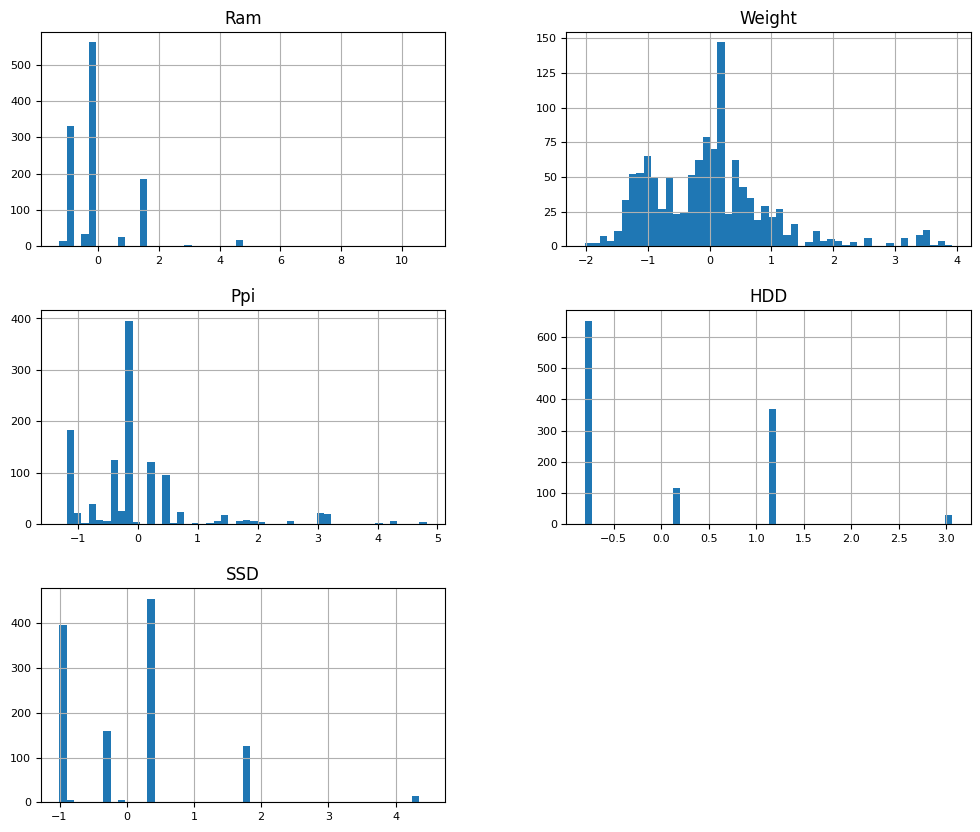

In [288]:
# histograma de cada variable numerica
df_laptops_train[featuresNumericas].hist(figsize=(12, 10), bins=50, xlabelsize=8, ylabelsize=8)


# 3. Ajustar un primer modelo

In [361]:

featuresActualizadas = list(df_laptops_train.columns)
featuresActualizadas.remove('Price')
X_train, X_test, y_train, y_test = train_test_split(df_laptops_train[featuresActualizadas], df_laptops_train['Price'], test_size = 0.2, random_state = 1)
print(featuresActualizadas)


['Ram', 'Weight', 'Ppi', 'HDD', 'SSD', 'Company_Asus', 'Company_Dell', 'Company_HP', 'Company_Lenovo', 'Company_MSI', 'Company_Mediacom', 'Company_Others_Company', 'Company_Toshiba', 'TypeName_Gaming', 'TypeName_Netbook', 'TypeName_Notebook', 'TypeName_Others_TypeName', 'TypeName_Ultrabook', 'TouchScreen_1', 'Ips_1', 'Cpu_brand_Intel Core i3', 'Cpu_brand_Intel Core i5', 'Cpu_brand_Intel Core i7', 'Cpu_brand_Other Intel Processor', 'Gpu_brand_Intel', 'Gpu_brand_Nvidia', 'Os_Windows']


In [362]:
# revisar datos de entrenamiento
X_train.describe()

,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows
count,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000,932.000000
mean,0.001004,0.010884,0.007475,-0.019900,0.011265,0.123391,0.222103,0.199571,0.238197,0.040773,0.004292,0.050429,0.038627,0.166309,0.012876,0.546137,0.027897,0.151288,0.148069,0.284335,0.108369,0.317597,0.424893,0.107296,0.538627,0.330472,0.860515
std,1.018837,0.998076,1.020830,0.982326,0.986326,0.329062,0.415883,0.399892,0.426209,0.197869,0.065407,0.218946,0.192807,0.372558,0.112798,0.498134,0.164766,0.358521,0.355359,0.451339,0.311013,0.465792,0.494592,0.309656,0.498773,0.470636,0.346638
min,-1.267613,-2.017709,-1.312430,-0.801703,-1.004100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.878041,-0.772105,-0.451469,-0.801703,-1.004100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,-0.098897,-0.001017,-0.126402,-0.801703,0.363260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
75%,-0.098897,0.399355,0.251660,1.131030,0.363260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,10.809123,3.928566,4.822424,3.063763,4.465341,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [363]:
# Mostrar filas con valores nulos
X_train[X_train.isnull().any(axis=1)]


,Ram,Weight,Ppi,HDD,SSD,Company_Asus,Company_Dell,Company_HP,Company_Lenovo,Company_MSI,Company_Mediacom,Company_Others_Company,Company_Toshiba,TypeName_Gaming,TypeName_Netbook,TypeName_Notebook,TypeName_Others_TypeName,TypeName_Ultrabook,TouchScreen_1,Ips_1,Cpu_brand_Intel Core i3,Cpu_brand_Intel Core i5,Cpu_brand_Intel Core i7,Cpu_brand_Other Intel Processor,Gpu_brand_Intel,Gpu_brand_Nvidia,Os_Windows


In [364]:
regression = LinearRegression()

In [351]:
# revision de valores NaN existentes en el dataset
X_train.isnull().sum()


Ram                                0
Weight                             0
Ppi                                0
HDD                                0
SSD                                0
Company_Asus                       0
Company_Dell                       0
Company_HP                         0
Company_Lenovo                     0
Company_MSI                        0
Company_Mediacom                   0
Company_Others_Company             0
Company_Toshiba                    0
TypeName_Gaming                    0
TypeName_Netbook                   0
TypeName_Notebook                  0
TypeName_Others_TypeName           0
TypeName_Ultrabook                 0
TouchScreen_1                      0
Ips_1                              0
Cpu_brand_Intel Core i3            0
Cpu_brand_Intel Core i5            0
Cpu_brand_Intel Core i7            0
Cpu_brand_Other Intel Processor    0
Gpu_brand_Intel                    0
Gpu_brand_Nvidia                   0
Os_Windows                         0
d

In [365]:
regression.fit(X_train, y_train)

LinearRegression()

### 3.1. Interpretación de los coeficientes y el intercepto

In [366]:
pd.DataFrame(regression.coef_, index=X_train.columns, columns=['Coeficiente'])

,Coeficiente
Ram,-0.573512
Weight,-2.074778
Ppi,-1.319584
HDD,1.653437
SSD,3.722690
Company_Asus,0.619932
Company_Dell,1.314419
Company_HP,3.411221
Company_Lenovo,3.212618
Company_MSI,2.405480


In [367]:
regression.intercept_

-0.3860318038282191

<Axes: >

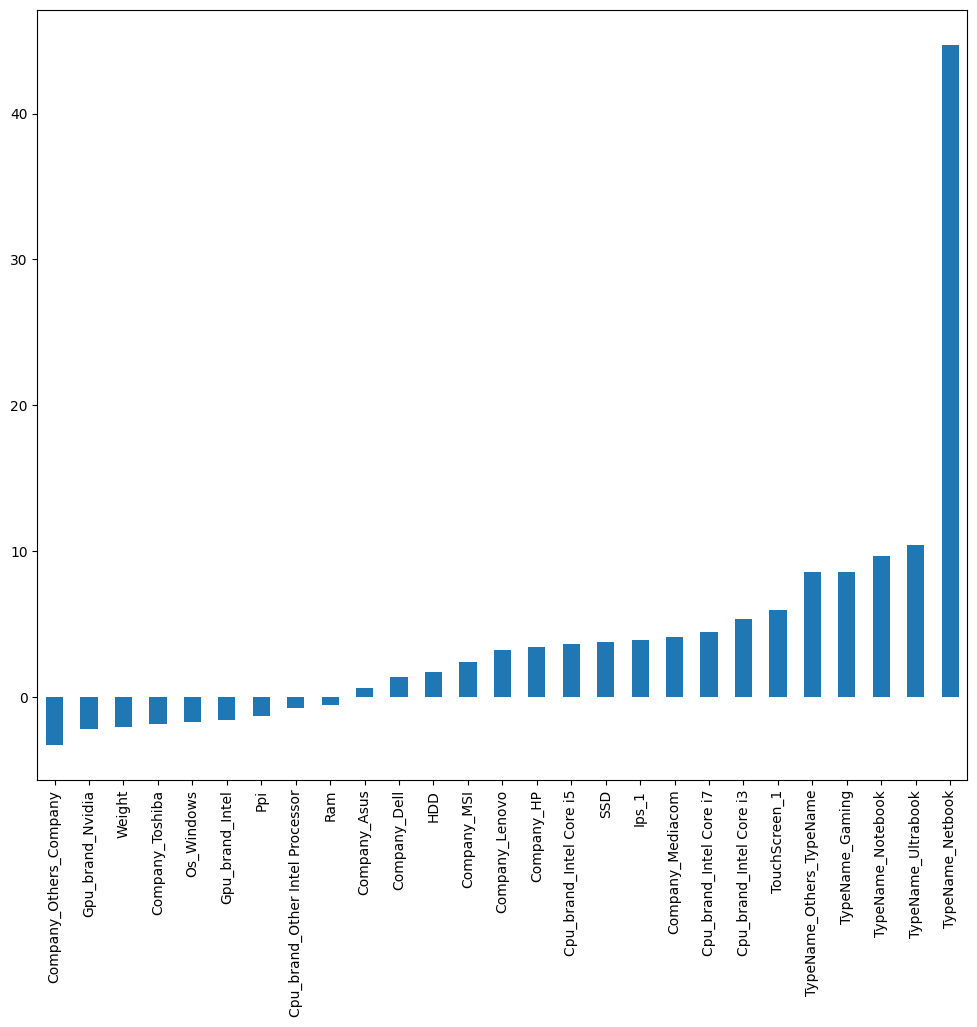

In [368]:

# Gráfico de barras de los coeficientes ordenados de mayor a menor ignorando Price
pd.Series(regression.coef_, index=X_train.columns).sort_values().plot(kind='bar', figsize=(12, 10))


# 4. Validar modelo

### 4.1. Prueba de significancia

In [369]:
# Prueba de significancia individual de las variables. 
# Se utiliza el p-value para determinar si la variable es significativa o no
# Si el p-value es menor a 0.05, la variable es significativa, es decir, tiene un efecto sobre la variable dependiente
# Si el p-value es mayor a 0.05, la variable no es significativa, es decir, no tiene un efecto sobre la variable dependiente


X_train_sm = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_sm).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     1.607
Date:                Fri, 15 Sep 2023   Prob (F-statistic):             0.0264
Time:                        01:16:22   Log-Likelihood:                -4384.3
No. Observations:                 932   AIC:                             8825.
Df Residuals:                     904   BIC:                             8960.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.3860      7.974     -0.048      0.961     -16.036      15.264
Ram                                -0.5735      1.465     -0.391      0.696      -3.450       2.303
Weight                             -2.0748      1.636     -1.268      0.205      -5.285       1.136
Ppi                                -1.3196      1.268     -1.041      0.298      -3.808       1.169
HDD                                 1.6534      1.313      1.260      0.208      -0.923       4.229
SSD                                 3.7227      1.538      2.420      0.016       0.704       6.742
Company_Asus                        0.6199      4.294      0.144      0.885      -7.808       9.047
Company_Dell                        1.3144      4.005      0.328      0.743      -6.546       9.175
Company_HP                          3.4112      3.878      0.880      0.379      -4.200      11.022
Company_Lenovo                      3.2126      3.707      0.867      0.386      -4.062      10.487
Company_MSI                         2.4055      6.400      0.376      0.707     -10.155      14.966
Company_Mediacom                    4.0777     14.354      0.284      0.776     -24.094      32.249
Company_Others_Company             -3.2900      5.571     -0.591      0.555     -14.224       7.644
Company_Toshiba                    -1.8563      5.803     -0.320      0.749     -13.245       9.533
TypeName_Gaming                     8.5760      6.560      1.307      0.191      -4.299      21.451
TypeName_Netbook                   44.7334      9.545      4.687      0.000      26.001      63.466
TypeName_Notebook                   9.6379      5.331      1.808      0.071      -0.825      20.101
TypeName_Others_TypeName            8.5620      7.823      1.095      0.274      -6.791      23.915
TypeName_Ultrabook                 10.4222      5.315      1.961      0.050      -0.009      20.853
TouchScreen_1                       5.9502      4.540      1.311      0.190      -2.959      14.860
Ips_1                               3.8704      2.371      1.632      0.103      -0.784       8.524
Cpu_brand_Intel Core i3             5.3252      6.128      0.869      0.385      -6.701      17.351
Cpu_brand_Intel Core i5             3.5971      5.772      0.623      0.533      -7.731      14.925
Cpu_brand_Intel Core i7             4.4013      5.747      0.766      0.444      -6.878      15.680
Cpu_brand_Other Intel Processor    -0.8179      6.526     -0.125      0.900     -13.625      11.989
Gpu_brand_Intel                    -1.5939      3.703     -0.430      0.667      -8.860       5.673
Gpu_brand_Nvidia                   -2.1967      3.973     -0.553      0.580      -9.993       5.600
Os_Windows                         -1.7246      2.807     -0.614      0.539      -7

Solo 3 de las 36 variables superaron la prueba t. `revisar` #TODO #1

### 4.2. Métricas de calidad

In [370]:
y_pred = regression.predict(X_test)

#### 4.2.1. MAE

In [371]:
print('Train:', mean_absolute_error(y_train, regression.predict(X_train)))
print('Test:', mean_absolute_error(y_test, y_pred))


Train: 5.760431653886053
Test: 4.686922281228941


#### 4.2.2. RMSE

In [372]:
print('Train:', np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print('Test:', np.sqrt(mean_squared_error(y_test, y_pred)))

Train: 26.71644226178768
Test: 7.937639478634721


#### 4.2.3. $R^2$

In [373]:
# R2
print('Train:', r2_score(y_train, regression.predict(X_train)))
print('Test:', r2_score(y_test, y_pred))

Train: 0.045795712326965776
Test: -164.5209087570526


#### 4.2.4. Análisis del error

/Users/duman/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


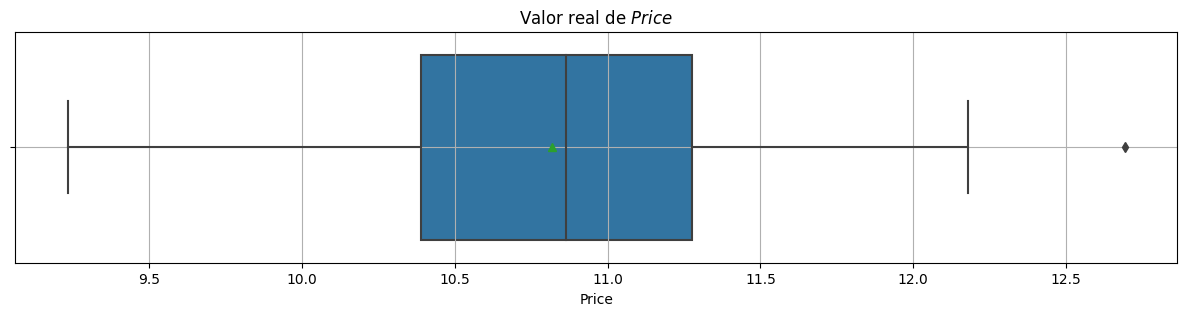

In [374]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = y_test, showmeans = True, orient = 'h')
plt.title('Valor real de $\t{Price}$')
plt.grid()
plt.show()

In [375]:
y_test.describe()

count    234.000000
mean      10.817837
std        0.618294
min        9.232535
25%       10.389423
50%       10.862093
75%       11.276708
max       12.691441
Name: Price, dtype: float64

/Users/duman/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


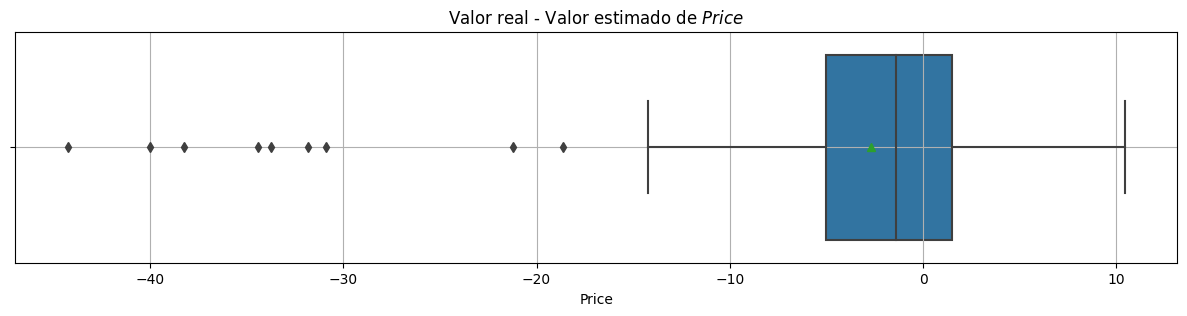

In [376]:
plt.figure(figsize = (15, 3))
sns.boxplot(x = (y_test - regression.predict(X_test)), showmeans = True, orient = 'h')
plt.title('Valor real - Valor estimado de $\t{Price}$')
plt.grid()
plt.show()

In [377]:
abs(y_test - regression.predict(X_test)).describe()

count    234.000000
mean       4.686922
std        6.419892
min        0.028720
25%        1.434509
50%        3.171272
75%        5.331530
max       44.254512
Name: Price, dtype: float64

# 5. Comprobación de supuestos

### 5.1. Correlación
Se acepta un nivel de correlación menor a ~$|0.8|$.

,Ram,Weight,Ppi,HDD,SSD
Ram,1.000000,0.401434,0.290125,0.088890,0.596536
Weight,0.401434,1.000000,-0.314977,0.510444,-0.049636
Ppi,0.290125,-0.314977,1.000000,-0.298250,0.501579
HDD,0.088890,0.510444,-0.298250,1.000000,-0.403111
SSD,0.596536,-0.049636,0.501579,-0.403111,1.000000


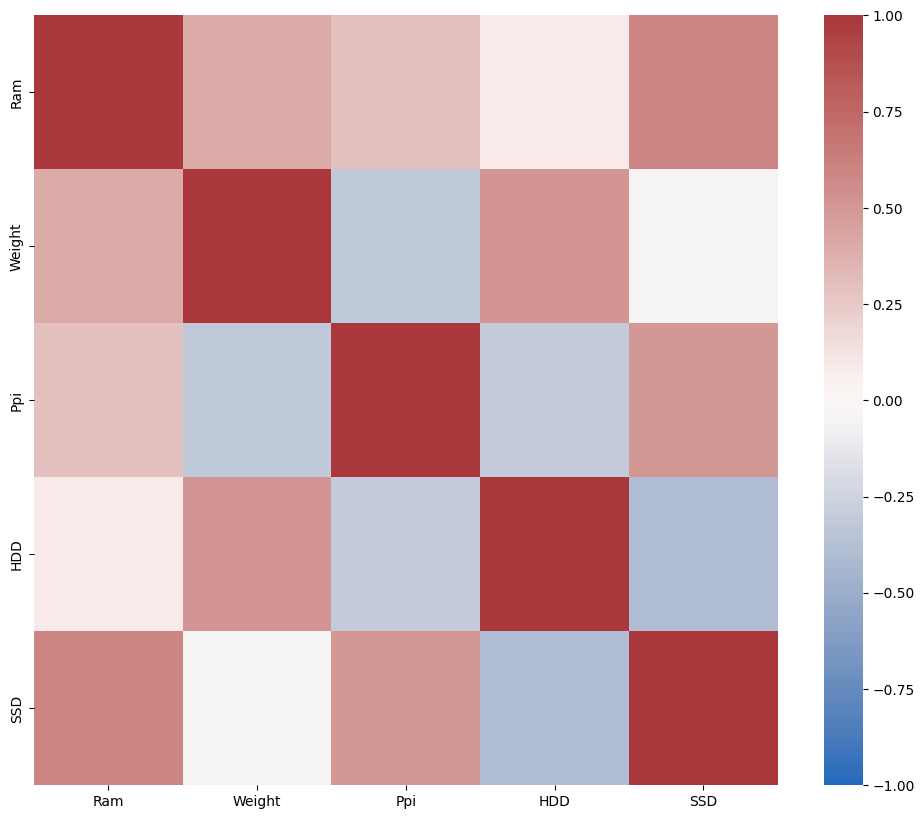

In [345]:
# Correlacion entre variables numericas
plt.figure(figsize = (12, 10))
sns.heatmap(df_laptops_train[featuresNumericas].corr(), cmap = 'vlag', vmin = -1, vmax = 1)
df_laptops_train[featuresNumericas].corr()


### 5.2. Homocedasticidad

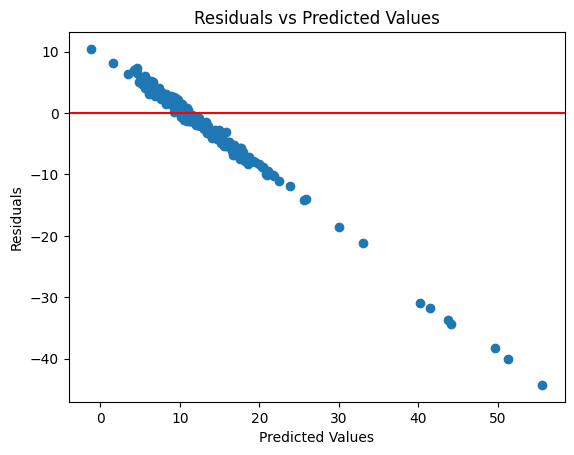

In [378]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()


#### 5.3 Normalidad

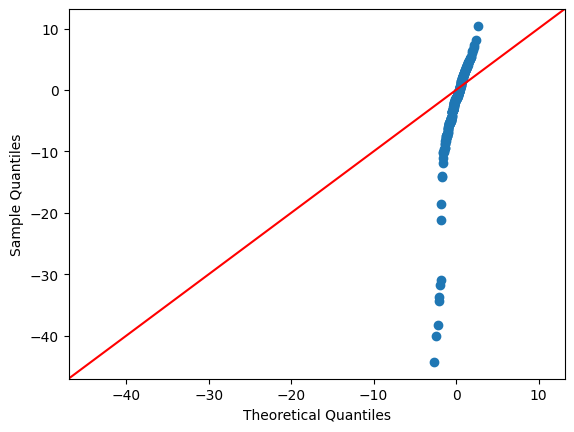

In [379]:
sm.qqplot(residuals, line='45')
plt.show()


#### 5.4. Multicolinealidad

In [380]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)


                           Variable        VIF
0                               Ram   2.792321
1                            Weight   3.371849
2                               Ppi   2.031905
3                               HDD   2.094824
4                               SSD   2.912825
5                      Company_Asus   2.601637
6                      Company_Dell   4.160180
7                        Company_HP   3.408719
8                    Company_Lenovo   3.624075
9                       Company_MSI   2.031531
10                 Company_Mediacom   1.118868
11           Company_Others_Company   1.908160
12                  Company_Toshiba   1.619216
13                  TypeName_Gaming   6.675058
14                 TypeName_Netbook   1.310680
15                TypeName_Notebook  10.869859
16         TypeName_Others_TypeName   1.810124
17               TypeName_Ultrabook   3.686996
18                    TouchScreen_1   2.775554
19                            Ips_1   1.965537
20          C

In [382]:
# Revisar datos atípicos numericamente
df_laptops_train[featuresNumericas].describe()

,Ram,Weight,Ppi,HDD,SSD
count,1.166000e+03,1.166000e+03,1.166000e+03,1.166000e+03,1.166000e+03
mean,-1.553931e-16,-2.071908e-16,-3.656309e-17,1.828155e-17,2.437539e-17
std,1.000429e+00,1.000429e+00,1.000429e+00,1.000429e+00,1.000429e+00
min,-1.267613e+00,-2.017709e+00,-1.312430e+00,-8.017029e-01,-1.004100e+00
25%,-8.780408e-01,-8.165913e-01,-4.514694e-01,-8.017029e-01,-1.004100e+00
50%,-9.889653e-02,-1.584602e-02,-1.264020e-01,-8.017029e-01,3.632601e-01
75%,-9.889653e-02,3.845266e-01,2.516596e-01,1.131030e+00,3.632601e-01
max,1.080912e+01,3.928566e+00,4.822424e+00,3.063763e+00,4.465341e+00


# 6. Pipeline

In [ ]:
# Crear un pipeline para el modelo de regresion lineal

# preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), featuresNumericas),
        ('encoder', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'), featuresCategoricas)
    ]
)

# Limpieza de datos
